Discard: First trial

In [1]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
import skimage.filters

In [25]:
from fft_conv_pytorch import fft_conv, FFTConv2d

In [26]:
img = np.load("/home/weniger/codes/pyrofit-lensing-analysis/mock_data/sources/hoags_object.npy")
img = skimage.transform.resize(img, [200, 200])

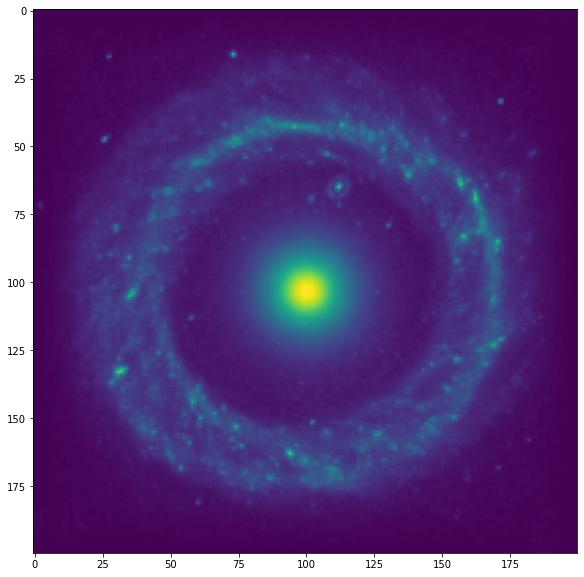

In [27]:
plt.figure(figsize = (10, 10))
plt.imshow(img)

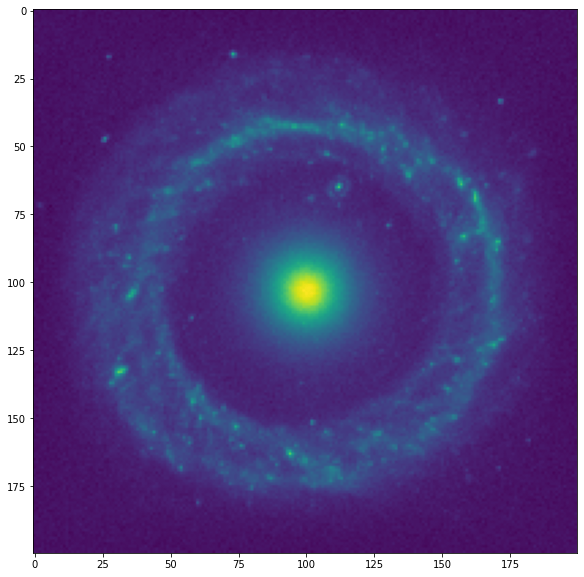

In [28]:
noise = np.random.randn(*img.shape)*0.01
plt.figure(figsize = (10, 10))
noisy = img + noise
plt.imshow(noisy)

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


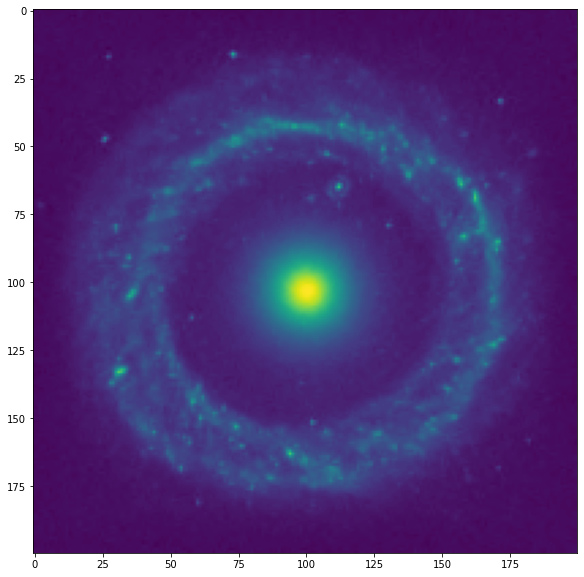

In [29]:
#denoised = skimage.restoration.denoise_tv_chambolle(noisy)
#denoised = skimage.restoration.denoise_wavelet(noisy)
denoised = skimage.restoration.denoise_wavelet(noisy, mode = 'soft', wavelet_levels = 4, wavelet = 'sym9')
plt.figure(figsize = (10, 10))
plt.imshow(denoised)

In [30]:
import torch

In [31]:
import torch.nn as nn

In [32]:
img = torch.randn(1, 1, 400, 400).cuda()

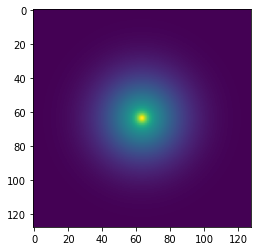

In [33]:
K = 128

kernel = np.zeros((K, K))
x = np.linspace(-100, 100, K)
X, Y = np.meshgrid(x, x)
R = (X**2 + Y**2)**0.5

for a, s in [[100.0, 30], [10, 15], [2, 5], [0.2, 2]]:
    kern = np.exp(-0.5*R**2/s**2)
    kern /= kern.sum()
    kernel += a*kern
    
plt.imshow(kernel)

In [34]:
kernel_gpu = torch.tensor(kernel).float()

In [35]:
gaussian_weights = nn.Parameter(kernel_gpu.unsqueeze(0).unsqueeze(0).cuda())
conv = FFTConv2d(in_channels = 1, out_channels = 1, kernel_size=K, bias=False, padding = 64)
with torch.no_grad():
    conv.weight = gaussian_weights

In [49]:
seeds = torch.randn(400, 400).cuda()

In [47]:
imgc = conv(seeds.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
imgc = torch.exp(imgc)
img = imgc.detach().cpu().numpy()

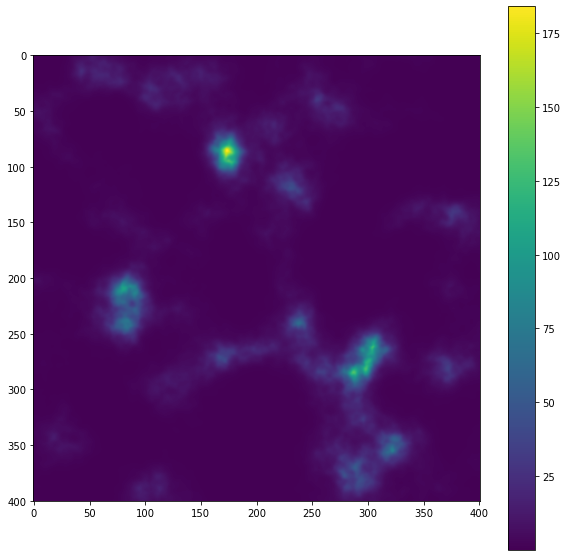

In [48]:
plt.figure(figsize = (10, 10))
plt.imshow(img)
plt.colorbar()

In [50]:
def model(seeds):
    imgc = conv(seeds.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
    imgc = torch.exp(imgc*0.5)
    #imgc = torch.nn.functional.softplus(imgc)
    #imgc = torch.nn.functional.leaky_relu(imgc)
    return imgc

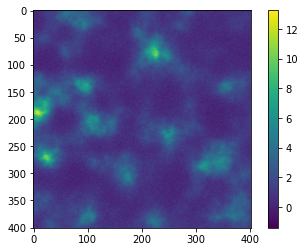

In [60]:
seeds = torch.randn(400, 400).cuda()
img0 = model(seeds).detach()
sigma= 0.4 * torch.ones_like(img0)
#sigma[150:] += 40
noise = torch.randn(img0.shape).cuda()*sigma
img0n = img0+noise
plt.imshow(img0n.detach().cpu())
plt.colorbar()

In [61]:
img = model(seeds)

In [69]:
seeds = torch.randn(400, 400).cuda()
G = torch.ones_like(seeds)
alpha = 0.05

In [70]:
for _ in range(100):
    seeds.requires_grad = True
    img = model(seeds)
    sn = 0.5*((img - img0n)**2)/sigma**2
    loss = sn.sum()#*1e-2
    #loss = torch.where(sn < 0, torch.zeros(sn.size()).cuda(), sn).sum()
    loss += (seeds**2).sum()*0.5
    #print(seeds.grad)
    loss.backward()
    #tau = 1e-4
    epsilon = 1e-3
    
    #print(seeds.grad)
    G = (1-alpha)*G + alpha*seeds.grad**2
    M = 1/(G**0.5 + 1e-8)
    tau = epsilon*M
    eta = (tau*2)**0.5
    step = -tau*seeds.grad
    seeds = seeds.detach() + step + torch.randn(step.size()).cuda()*eta
    #up = u - epsilon * u_grad
    #w = 0.01
    #up[:,:-1] = up[:,:-1] + torch.randn(u[:,:-1].size())*w
    #u = u.detach()
    #up = up.detach()
    #u = torch.where(up > 0., torch.where(up < 1., up, u), u)

0.99810874


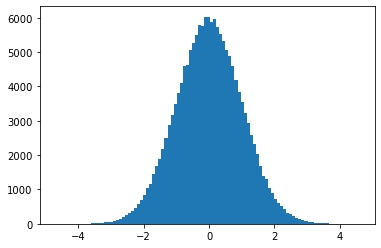

In [71]:
s = seeds.cpu().numpy().flatten()
print(s.std())
plt.hist(s, bins = 100);

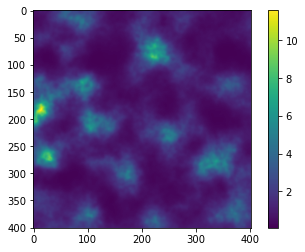

In [72]:
img = model(seeds)
plt.imshow(img.detach().cpu())
plt.colorbar()

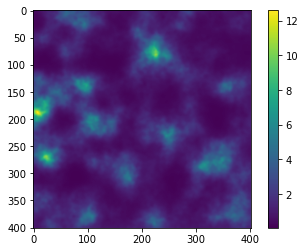

In [73]:
plt.imshow(img0.detach().cpu())
plt.colorbar()

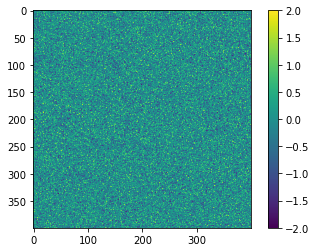

In [67]:
plt.imshow(seeds.cpu(), vmin = -2, vmax = 2)
plt.colorbar()

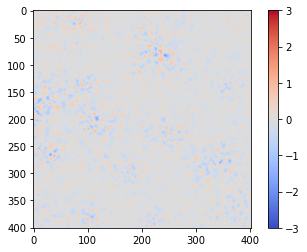

In [68]:
plt.imshow(img.detach().cpu() - img0.detach().cpu(), vmin = -3, vmax = 3, cmap = 'coolwarm')
plt.colorbar()